In [1]:
!pip install diffusers

In [2]:
import torch
from diffusers import DDPMScheduler
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# 加载图像并进行预处理
def load_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((1007,800)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)


image_path = '/content/jake-nackos-IF9TK5Uy-KI-unsplash.jpg'  # 替换为实际图像路径
clean_image = load_image(image_path).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [3]:
# 定义DDPM调度器
noise_scheduler = DDPMScheduler(num_train_timesteps=500)

# 生成噪声图像
timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (clean_image.shape[0],), device=clean_image.device).long()
noisy_images = noise_scheduler.add_noise(clean_image, torch.randn_like(clean_image), timesteps)

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


In [4]:
# 显示原始图像和添加噪声后的图像
def show_image(tensor, title='Image'):
    image = tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    plt.imshow((image * 0.5) + 0.5)
    plt.title(title)
    plt.axis('off')
    plt.show()

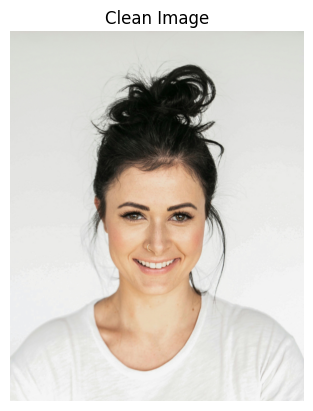

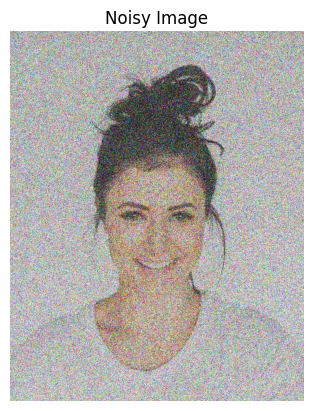

In [5]:
# 顯示圖片
show_image(clean_image, 'Clean Image')
show_image(noisy_images, 'Noisy Image')

In [6]:
!git clone https://github.com/DmitryUlyanov/deep-image-prior
!mv deep-image-prior/* ./

fatal: destination path 'deep-image-prior' already exists and is not an empty directory.
mv: cannot stat 'deep-image-prior/*': No such file or directory


In [ ]:
import torch
import numpy as np
import math

def calculate_psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    psnr = 20 * math.log10(1.0 / math.sqrt(mse))
    return psnr

In [ ]:
import torch.optim
from models import get_net
from utils.inpainting_utils import np_to_torch, torch_to_np
import numpy as np

# 定义DIP模型
net = get_net(3, 'skip', 'reflection', n_channels=3,
              skip_n33d=64, skip_n33u=64, skip_n11=2,
              num_scales=3, upsample_mode='bilinear').to(clean_image.device)
mse = torch.nn.MSELoss().to(clean_image.device)

# 将噪声图像转换为DIP模型输入格式
noisy_image_np = torch_to_np(noisy_images)
noisy_image_var = np_to_torch(noisy_image_np).to(clean_image.device)

# 初始化DIP模型输入
net_input = torch.randn_like(noisy_image_var).detach().to(clean_image.device)

# DIP训练循环
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
num_iter = 1000  # 训练迭代次数

for i in range(num_iter):
    optimizer.zero_grad()
    out = net(net_input)
    loss = mse(out, noisy_image_var)
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        psnr = calculate_psnr(out, clean_image)
        print(f"Iteration {i}/{num_iter}, Loss: {loss.item()}, PSNR: {psnr}")

# 生成修复后的图像
restored_image = torch_to_np(net(net_input))

# 显示修复后的图像
show_image(torch.tensor(restored_image).unsqueeze(0), 'Restored Image')


Iteration 0/1000, Loss: 0.6709923148155212
Iteration 100/1000, Loss: 0.5645086169242859
